# Cauchy example

Here we approximate a Cauchy target $p(x)=(\pi(1+x^2))^{-1}$ 
with a Gaussian by minimizing both the forward and the reverse KL.

First we import some libraries and then we define relevant code. 

## Code

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import vi

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 28})
figpath='../doc/fig/'

In [2]:
##########################
##########################
#   cauchy target defn   #
##########################
##########################
def lp(x): return -np.log(1+x**2)-np.log(np.pi)
def randp(size): return np.random.standard_cauchy(size)

## Optimization

Here we minimize first the reverse KL and then the forward KL.

In [3]:
##########################
##########################
#    reverse KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=10001
B=10000 # monte carlo sample size for gradient estimation
lr_mu=1e1
lr_lsigma=1e1
divergence='rev-kl'

rev_mus,rev_lsigmas=vi.gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | 6.67839608484994   | 6667.959742638883   | -0.8089341133284977  | -0.9085391091811823
  1000   | 0.00094020128376102   | 1.6486862454013598   | -0.001261412073914488  | 0.004141443392315613
  2000   | 0.003910347676078475   | 1.644938343274284   | 0.0009418228271306582  | 0.024794787290442905
  3000   | 0.0008474207767216312   | 1.641579348947717   | 0.0009158101809678974  | 0.0048999277756437785
  4000   | -0.0014572119815890175   | 1.642665632871073   | 0.002716916405600724  | 0.01350844782028627
  5000   | -0.0003502833744694376   | 1.6375330279184088   | 0.0031582762359665816  | 0.025029247057568732
  6000   | 0.0004166671782055221   | 1.645768011043134   | -0.0009134212404090628  | 0.004625928761469304
  7000   | -0.004351160995914036   | 1.6372207915051906   | 0.0022037356535213556  | -0.030040620881970004
  8000   | 0.000

In [4]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

rev_mu=rev_mus[-1]
rev_lsigma=rev_lsigmas[-1]

rev_lq = lambda x : vi.lq(x,rev_mu,rev_lsigma)
rev_randq = lambda B : rev_mu+np.exp(rev_lsigma)*np.random.randn(B)

In [5]:
##########################
##########################
#    forward KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=10001
B=10000 # monte carlo sample size for gradient estimation
lr_mu=1e-1
lr_lsigma=1e-11
divergence='fwd-kl'

fwd_mus,fwd_lsigmas=vi.gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.9644684106014652   | 0.7555405779209228   | -4.4647663783357245  | -9666.545373536233
  1000   | 0.03473601161315043   | 5.2815241030542435   | -0.043137704947975274  | -374.13324831017894
  2000   | -0.10813123856687222   | 5.282806955572553   | 1.3070702815178292  | -164.5277378465556
  3000   | -0.027903724958935675   | 5.285018026816807   | -0.04385776961680918  | -84.70163743982204
  4000   | 0.030034980312466982   | 5.285044511129903   | 0.001867898279970951  | -3644.487352863359
  5000   | -0.0032152292971904897   | 5.285491468931587   | -0.020242288078850357  | -80.15206488856133
  6000   | -0.012702526985727377   | 5.285590572362497   | 0.04490184561764447  | -182.9870421514953
  7000   | -0.007539453420878413   | 5.286291350975518   | 0.019501692047503117  | -76.03771034133237
  8000   | 0.00933320130337748   | 5.28

In [6]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

fwd_mu=fwd_mus[-1]
fwd_lsigma=fwd_lsigmas[-1]

fwd_lq = lambda x : vi.lq(x,fwd_mu,fwd_lsigma)
fwd_randq = lambda B : fwd_mu+np.exp(fwd_lsigma)*np.random.randn(B)

## Diagnostics

Now we generate diagnostic plots.
Specifically,
first a logpdf plot comparing the exact target logpdf with both approximations.
Then, a comparison of the credible interval limits for different credibility limits.
Finally, an analysis of the coverage of the intervals as a function of the credibility.

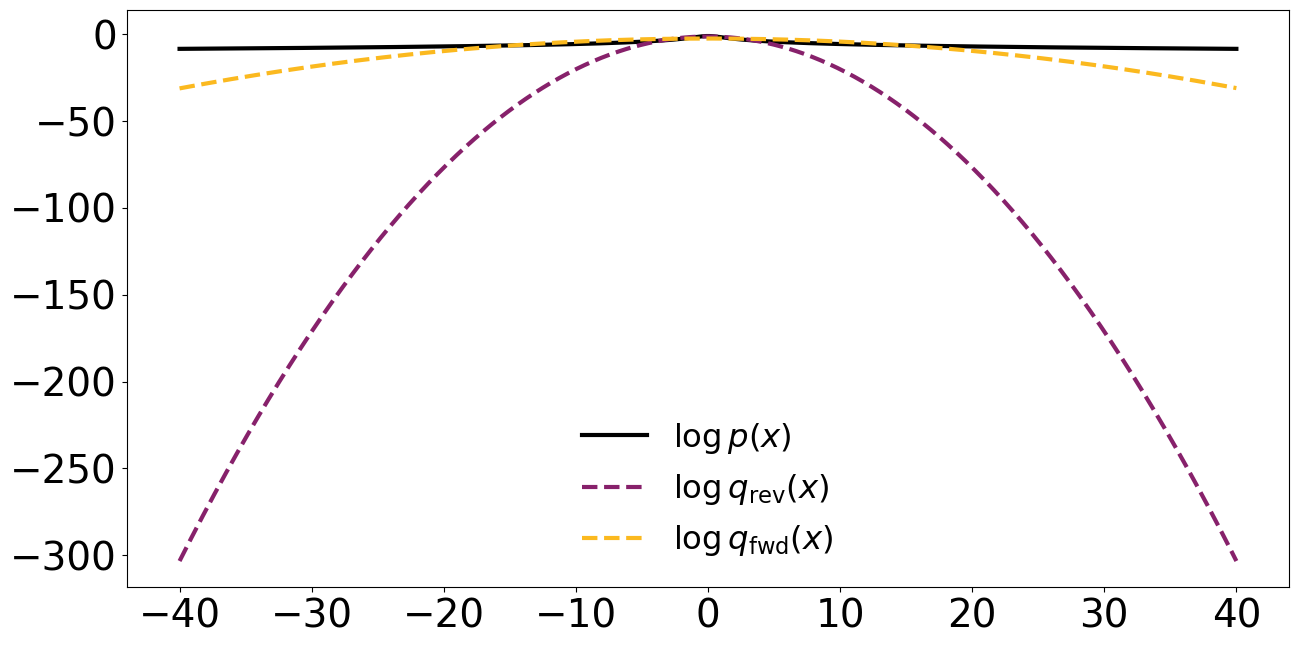

In [34]:
lsx=np.linspace(-40,40,1000)
plt.plot(lsx,lp(lsx),c="black", label=r'$\log p(x)$',lw=3)
plt.plot(lsx,rev_lq(lsx),c='#87216BFF', label=r'$\log q_{\mathrm{rev}}(x)$',lw=3,ls='dashed')
plt.plot(lsx,fwd_lq(lsx),c='#FBB91FFF', label=r'$\log q_{\mathrm{fwd}}(x)$',lw=3,ls='dashed')
plt.legend(fontsize='small',frameon=False)
plt.savefig(figpath + 'cauchy_logq.pdf', dpi=300, bbox_inches='tight')

In [8]:
rev_kl=vi.kl(rev_lq,lp,rev_randq,B=10000)
fwd_kl=vi.kl(lp,fwd_lq,randp,B=10000)
print('Reverse KL: '+str(rev_kl))
print('Forward KL: '+str(fwd_kl))

Reverse KL: 0.18654597508490378
Forward KL: 370.4228356929126


### Credible interval comparison

In [9]:
alphas=np.flip(np.linspace(0.01,0.2,101)[1:])
true_lims=stats.cauchy.ppf(1-alphas/2)
rev_lims=stats.norm.ppf(1-alphas/2,loc=rev_mu,scale=np.exp(rev_lsigma))
fwd_lims=stats.norm.ppf(1-alphas/2,loc=fwd_mu,scale=np.exp(fwd_lsigma))

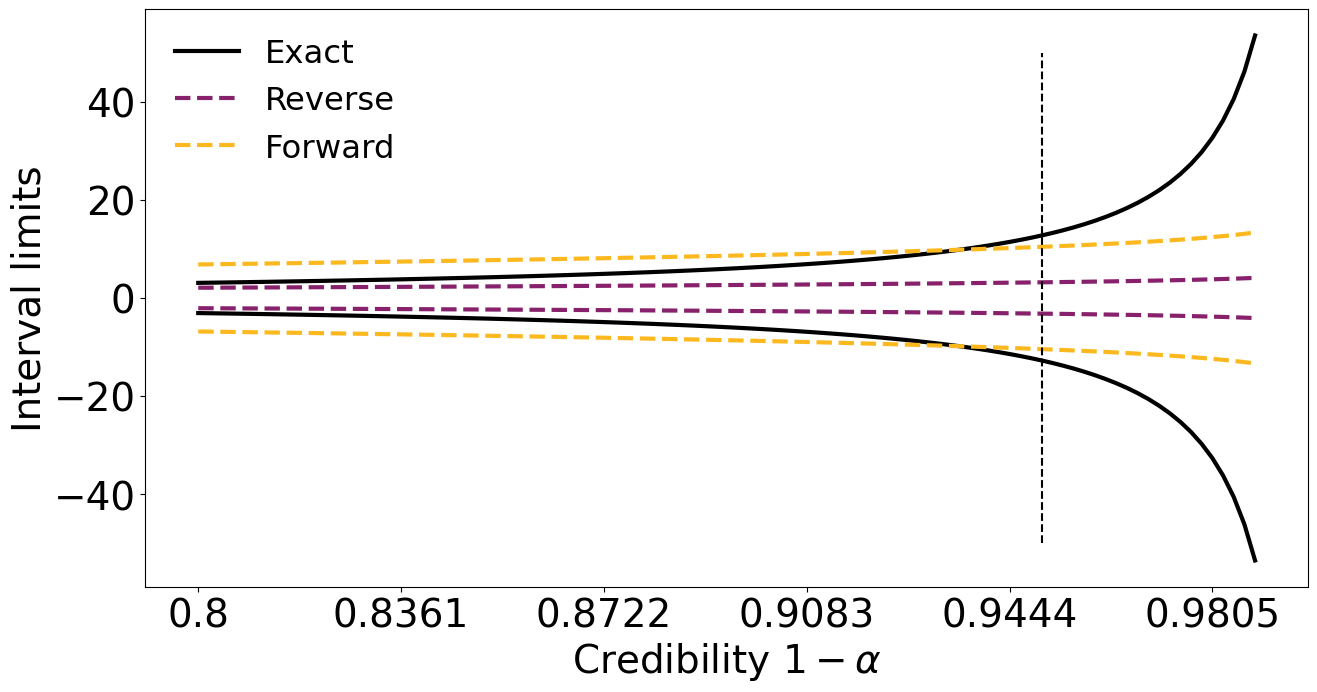

In [32]:
plt.plot(lsa,true_lims,label='Exact',c='black',lw=3)
plt.plot(lsa,-true_lims,label='',c='black',lw=3)
plt.plot(lsa,rev_lims,label='Reverse',c='#87216BFF',lw=3,ls='dashed')
plt.plot(lsa,-rev_lims,label='',c='#87216BFF',lw=3,ls='dashed')
plt.plot(lsa,fwd_lims,label='Forward',c='#FBB91FFF',lw=3,ls='dashed')
plt.plot(lsa,-fwd_lims,label='',c='#FBB91FFF',lw=3,ls='dashed')
plt.vlines(np.argmax(alphas==0.0499),-50,50,ls='dashed',color='black')

plt.ylabel('Interval limits')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');
plt.savefig(figpath + 'cauchy_cilims.pdf', dpi=300, bbox_inches='tight')

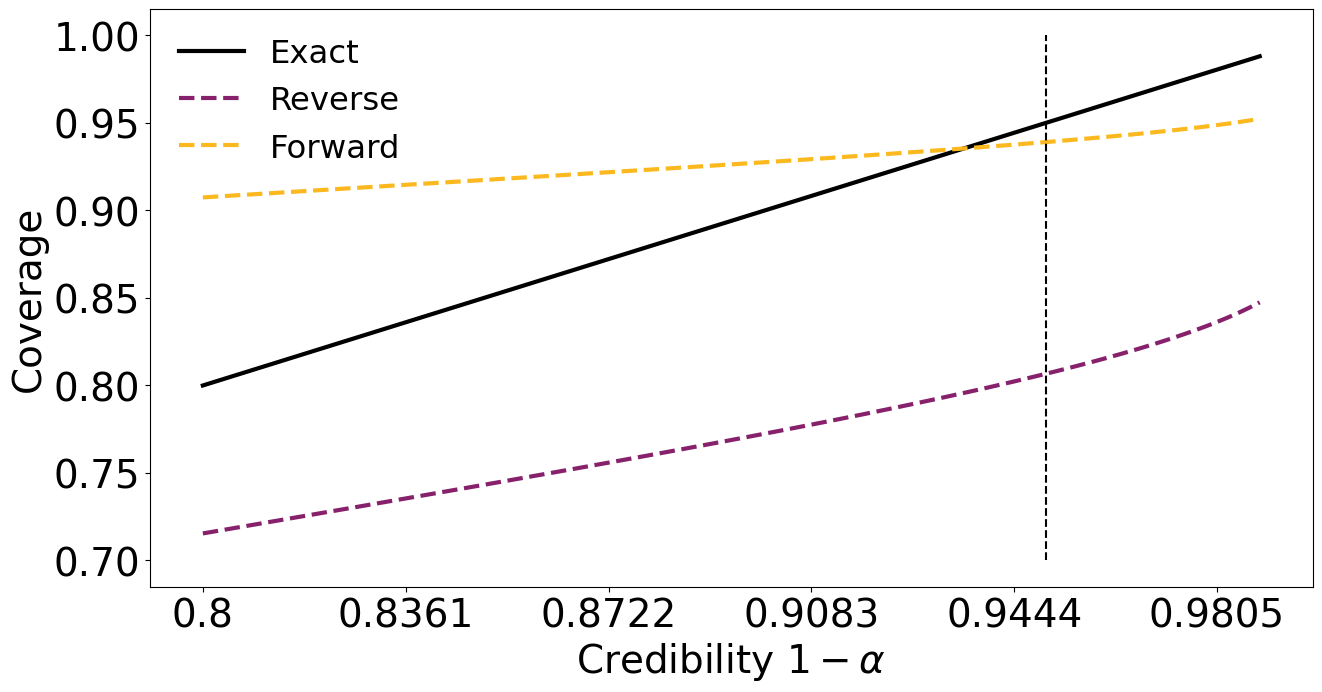

In [28]:
plt.plot(lsa,1-alphas[lsa],label='Exact',lw=3,color='black')
plt.plot(lsa,1-2*stats.cauchy.sf(rev_lims),label='Reverse',lw=3,color='#87216BFF',ls='dashed')
plt.plot(lsa,1-2*stats.cauchy.sf(fwd_lims),label='Forward',lw=3,color='#FBB91FFF',ls='dashed')
plt.vlines(np.argmax(alphas==0.0499),0.7,1,ls='dashed',color='black')

plt.ylabel(r'Coverage')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');
plt.savefig(figpath + 'cauchy_cicoverage.pdf', dpi=300, bbox_inches='tight')

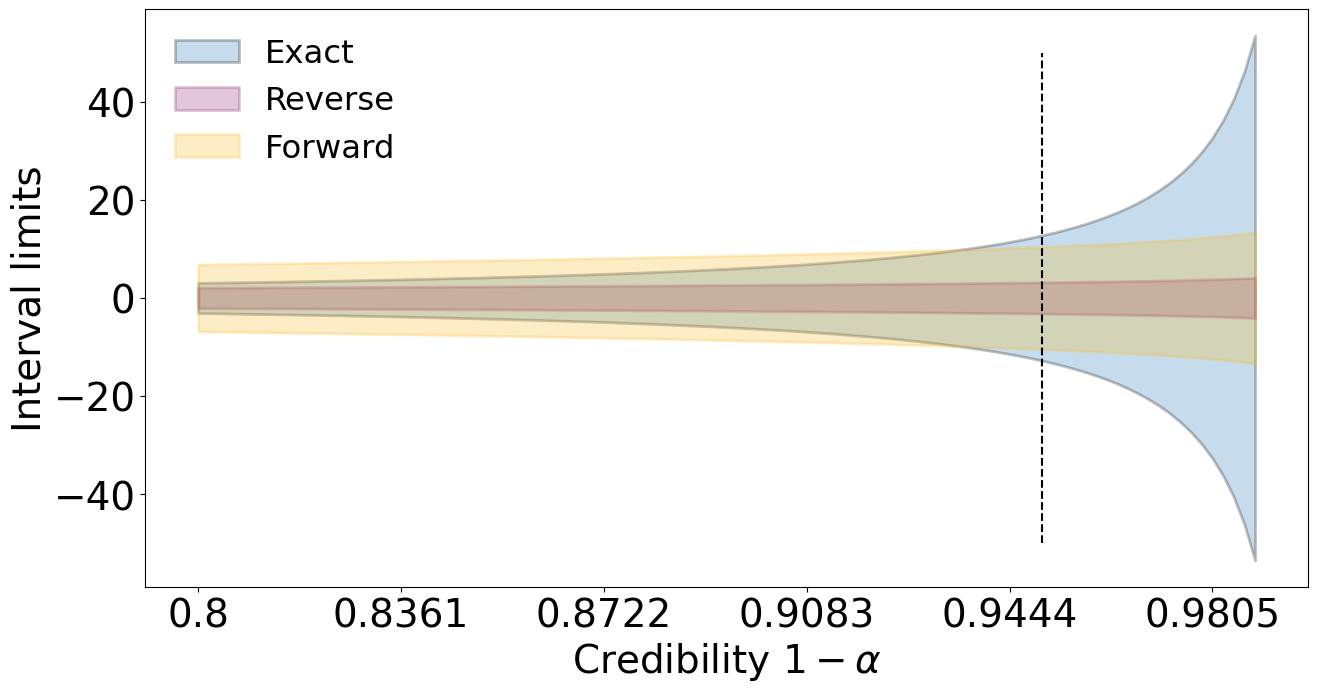

In [29]:
lsa=np.arange(0,alphas.shape[0])
#plt.errorbar(x=lsa,y=np.zeros(alphas.shape[0]),yerr=true_lims[1,:])
plt.fill_between(x=lsa,y1=true_lims,y2=-true_lims,label='Exact',alpha=0.25,ec='black',lw=2)
plt.fill_between(x=lsa,y1=rev_lims,y2=-rev_lims,label='Reverse',alpha=0.25,ec='black',lw=2,color='#87216BFF')
plt.fill_between(x=lsa,y1=fwd_lims,y2=-fwd_lims,label='Forward',alpha=0.25,ec='black',lw=2,color='#FBB91FFF')
plt.vlines(np.argmax(alphas==0.0499),-50,50,ls='dashed',color='black')

plt.ylabel('Interval limits')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');

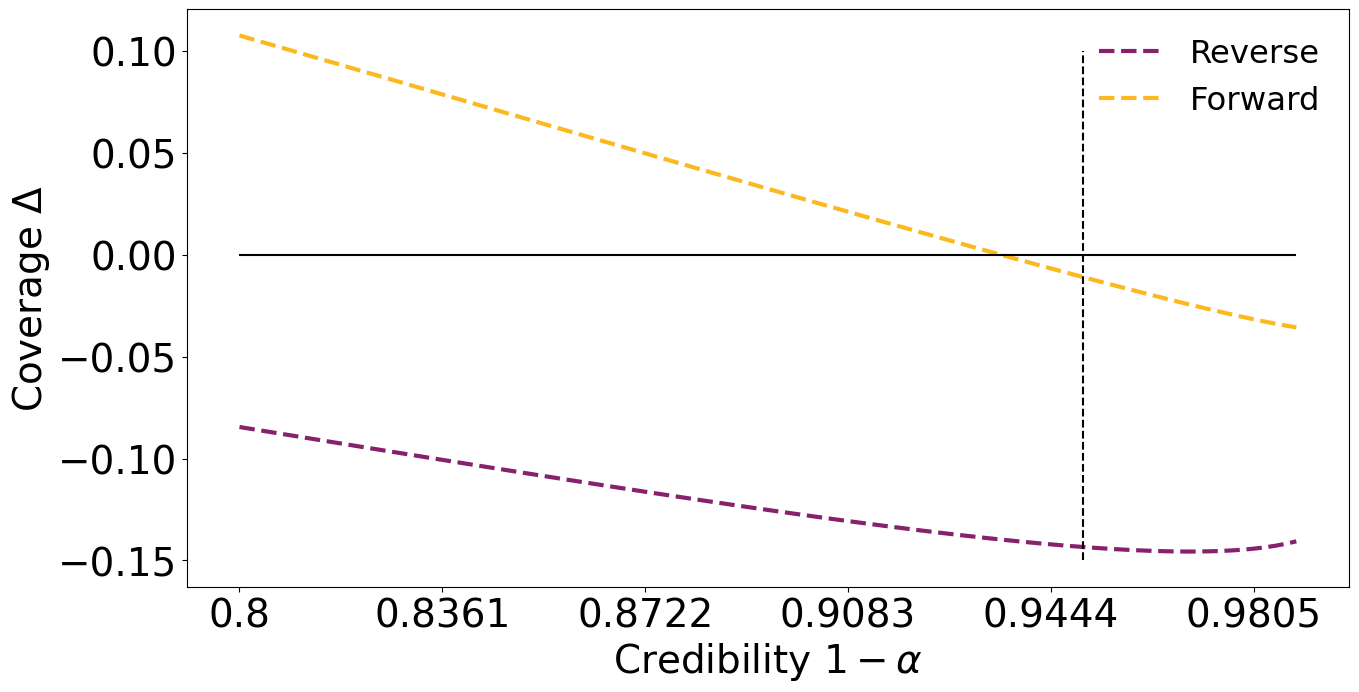

In [30]:
plt.plot(lsa,alphas-2*stats.cauchy.sf(rev_lims),label='Reverse',lw=3,color='#87216BFF',ls='dashed')
plt.plot(lsa,alphas-2*stats.cauchy.sf(fwd_lims),label='Forward',lw=3,color='#FBB91FFF',ls='dashed')
plt.hlines(0,lsa[0],lsa[-1],color='black')
plt.vlines(np.argmax(alphas==0.0499),-0.15,0.1,ls='dashed',color='black')

plt.ylabel(r'Coverage $\Delta$')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper right');